<a href="https://colab.research.google.com/github/nujl/Liberty-Data-Science/blob/main/1.Student%20Test%20Score%20Prediction/Student_Test_Scores_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

Python Packages

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

R Packages

In [ ]:
%%R
if(!require('pacman')) {
  install.packages('pacman')
}
pacman::p_load(ggplot2, dplyr, car, gridExtra)

---
# Data

In [5]:
%%R
df <- read.csv("https://raw.githubusercontent.com/nujl/Liberty-Data-Science/main/1.Student%20Test%20Score%20Prediction/test_scores.csv")
summary(df)

# https://www.kaggle.com/datasets/kwadwoofosu/predict-test-scores-of-students

    school          school_setting     school_type         classroom        
 Length:2133        Length:2133        Length:2133        Length:2133       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 teaching_method      n_student     student_id           gender         
 Length:2133        Min.   :14.0   Length:2133        Length:2133       
 Class :character   1st Qu.:20.0   Class :character   Class :character  
 Mode  :character   Median :22.0   Mode  :character   Mode  :character  
                    Mean   :22.8                                        
                    3rd Qu.:27.0                                        
                    Max

In [6]:
df = %R df
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
5,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [7]:
na_dict = {col:sum(df[col].isna()) for col in df.columns}
pd.Series(na_dict)

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

No null values

---
# EDA
- Categorical variables except classroom and student id

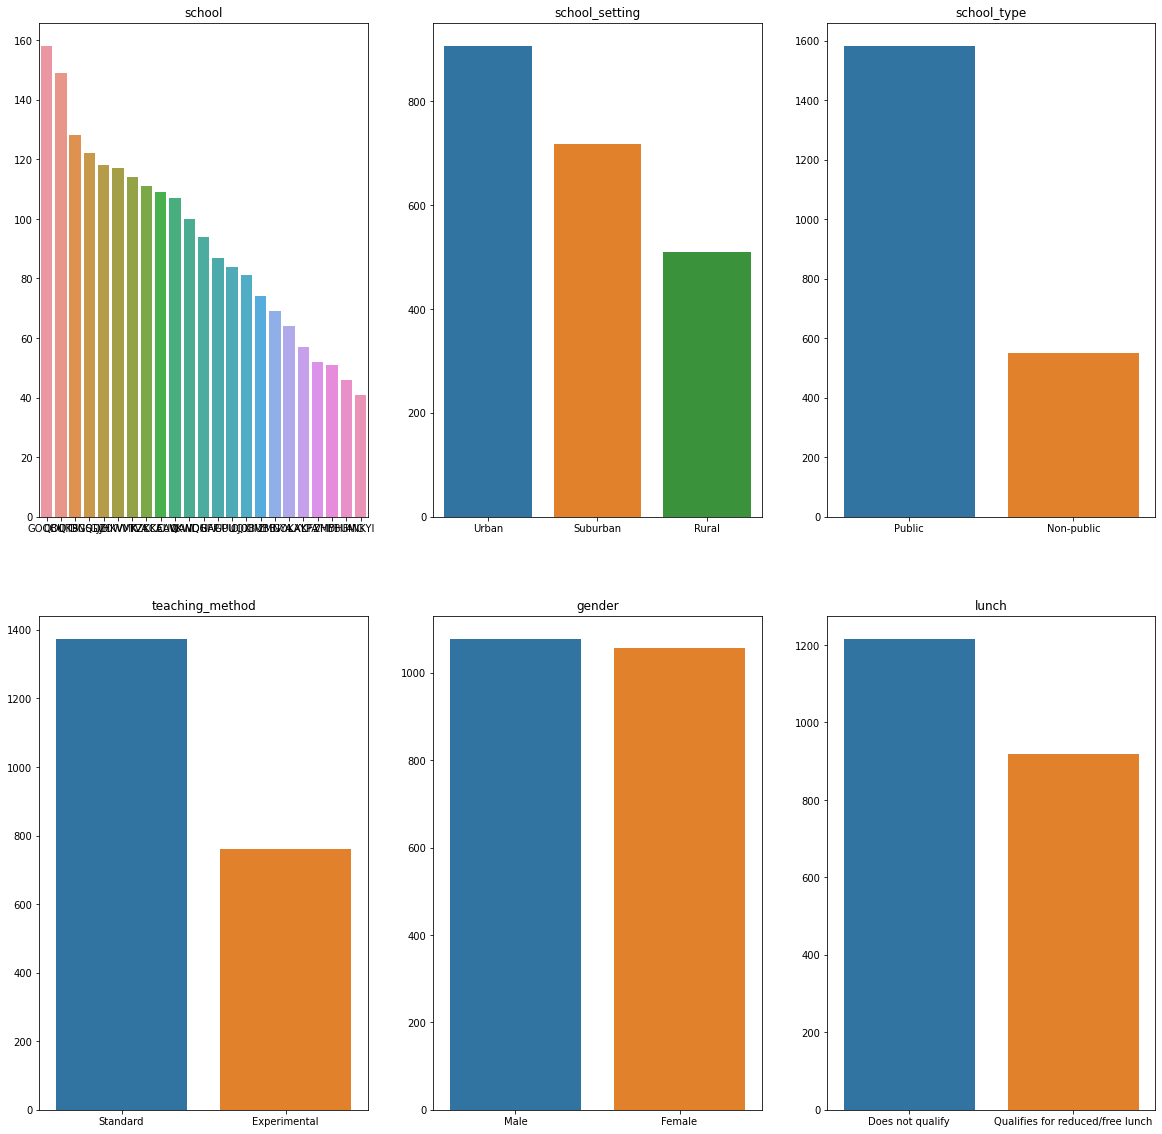

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = ["school", "school_setting", "school_type", "teaching_method", "gender", "lunch"]
cords = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
fig, axs = plt.subplots(2,3, figsize=(20, 20))

for i,col in enumerate(cat_cols):
    vals = df[col].value_counts().to_dict()
    sns.barplot(x=list(vals.keys()), y=list(vals.values()), ax=axs[cords[i]])
    axs[cords[i]].set_title(col)

- Numerical Variables

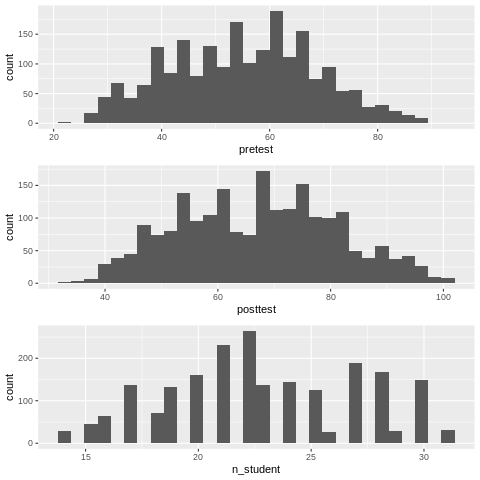

In [9]:
%%R
library(gridExtra)

p1 <- ggplot(df)+
  geom_histogram(aes(x=pretest))
p2 <- ggplot(df)+
  geom_histogram(aes(x=posttest))
p3 <- ggplot(df)+
  geom_histogram(aes(x=n_student))

grid.arrange(p1, p2, p3, nrow=3)

In [10]:
%%R
as.factor(df$n_student)
best_classes <- df %>%
  group_by(school, classroom) %>%
  summarise(
    score = mean(posttest)
  )
best_classes <- data.frame(best_classes)
head(best_classes[order(best_classes$score, decreasing=TRUE),])

`summarise()` has grouped output by 'school'. You can override using the
`.groups` argument.
   school classroom    score
42  IDGFP       P2A 98.41176
68  UKPGS       08N 93.85714
69  UKPGS       9AW 93.16000
40  IDGFP       98D 92.04762
70  UKPGS       IPU 91.52632
93  ZMNYA       V77 90.08696


In [11]:
%%R
df %>%
  group_by(school, classroom) %>%
  summarise(
      count = n()
  )

`summarise()` has grouped output by 'school'. You can override using the
`.groups` argument.
# A tibble: 97 × 3
# Groups:   school [23]
   school classroom count
   <chr>  <chr>     <int>
 1 ANKYI  6OL          20
 2 ANKYI  ZNS          21
 3 CCAAW  2B1          18
 4 CCAAW  EPS          20
 5 CCAAW  IQN          15
 6 CCAAW  PGK          21
 7 CCAAW  UHU          16
 8 CCAAW  UWK          19
 9 CIMBB  A33          19
10 CIMBB  EID          21
# … with 87 more rows


In [12]:
%%R 
df %>%
  group_by(lunch) %>%
  summarise(
      avg_posttest = mean(posttest),
      avg_pretest = mean(pretest)
  )

# A tibble: 2 × 3
  lunch                            avg_posttest avg_pretest
  <chr>                                   <dbl>       <dbl>
1 Does not qualify                         74.4        62.3
2 Qualifies for reduced/free lunch         57.5        45.2


- Students from UKPGS performed extremely well
- 23 schools, 97 classrooms in total
- Can't use student_id because they're all unique
- Distribution of posttest and pretest approximately normal, might have to scale for better performance, but I decided not to
- Might not need school since theres classroom data
- Somehow lunch might be a significant variable, probably because qualification for free lunch can indicate that ones not rich

---
# Multiple Regression using R

In [13]:
%%R
df.clean <- subset(df, select=-c(student_id))

#approx 3/4 of whole dataset
inds <- sample(nrow(df.clean), 1700)
train <- df.clean[inds,]
test <- df.clean[-inds,]

fit1 <- lm(posttest ~ ., data=train)
Anova(fit1)

      sums of squares computed by model comparison



Anova Table (Type II tests)

Response: posttest
                 Sum Sq   Df  F value    Pr(>F)    
school                     0                       
school_setting             0                       
school_type                0                       
classroom        4054.1   72   7.0353 < 2.2e-16 ***
teaching_method            0                       
n_student                  0                       
gender             41.1    1   5.1320   0.02362 *  
lunch             478.6    1  59.7962 1.848e-14 ***
pretest          2491.6    1 311.3177 < 2.2e-16 ***
Residuals       12805.5 1600                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
%%R
df.clean2 <- subset(df.clean, select=-c(school, school_setting, school_type, n_student, teaching_method)) # removed all variables that have no F statistic
fit2 <- lm(posttest ~ ., data=df.clean2)
Anova(fit2)

Anova Table (Type II tests)

Response: posttest
           Sum Sq   Df F value    Pr(>F)    
classroom 24117.9   96  32.291 < 2.2e-16 ***
gender       64.3    1   8.269  0.004075 ** 
lunch       572.5    1  73.579 < 2.2e-16 ***
pretest    3228.5    1 414.954 < 2.2e-16 ***
Residuals 15817.3 2033                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [15]:
%%R
df.clean3 <- subset(df.clean2, select=-c(gender)) # removed gender because pvalue > 0.001
fit.final <- lm(posttest ~ ., data=df.clean3)
Anova(fit.final)

Anova Table (Type II tests)

Response: posttest
           Sum Sq   Df F value    Pr(>F)    
classroom 24054.0   96  32.090 < 2.2e-16 ***
lunch       568.3    1  72.785 < 2.2e-16 ***
pretest    3317.8    1 424.915 < 2.2e-16 ***
Residuals 15881.6 2034                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R
summary(fit.final) # Final model, each classroom and lunch status are intercepts and pretest is the slope


Call:
lm(formula = posttest ~ ., data = df.clean3)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6090 -1.8041  0.0429  1.8096  9.6912 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            52.54662    1.60932  32.651  < 2e-16 ***
classroom08N                            5.92833    0.88078   6.731 2.19e-11 ***
classroom0N7                          -10.19068    0.98745 -10.320  < 2e-16 ***
classroom18K                          -14.43585    0.93482 -15.442  < 2e-16 ***
classroom197                           -0.65947    0.97832  -0.674 0.500334    
classroom1Q1                           -9.01785    0.86297 -10.450  < 2e-16 ***
classroom1SZ                           -9.12657    0.89153 -10.237  < 2e-16 ***
classroom1UU                            0.88288    0.83781   1.054 0.292102    
classroom1VD                          -11.17003    1.00150 -11.153  < 2e-16 ***
classroom21Q                          -

In [17]:
%%R
X_test <- subset(test, select=-c(school, school_setting, school_type, n_student, teaching_method, posttest))
Y_test <- subset(test, select=posttest)
preds <- predict(fit2, X_test)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def eval(ytest, pred):
    ytest = np.array(ytest)
    ytest.tolist()
    ytest = [y[0] for y in ytest]
    pred = np.array(pred)
    print(f"MSE: {mean_squared_error(ytest, pred)}")
    print(f"R2Score: {r2_score(ytest, pred)}")

    return ytest, pred

ytest = %R Y_test
pred = %R preds
ytest, pred = eval(ytest, pred)

MSE: 6.613964915616967
R2Score: 0.9645028963120237


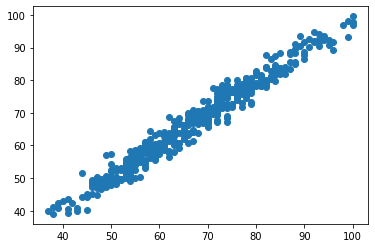

In [19]:
plt.scatter(ytest, pred)

# Neural Nets

In [20]:
df_new = df.drop(columns=["student_id"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
model = keras.Sequential()

model.add(keras.Input(shape=(X.shape[1])))

model.add(layers.Dense(256,kernel_initializer='normal',activation='relu'))

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(32,activation='relu'))

model.add(layers.Dense(1,activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               34304     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 77,569
Trainable params: 77,569
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mse"]
)

In [24]:
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=150, verbose=1
)

Epoch 1/150
12/12 [==============================] - 1s 24ms/step - loss: 4188.4360 - mse: 4188.4360 - val_loss: 3409.5862 - val_mse: 3409.5862
Epoch 2/150
12/12 [==============================] - 0s 9ms/step - loss: 2307.5872 - mse: 2307.5872 - val_loss: 640.4768 - val_mse: 640.4768
Epoch 3/150
12/12 [==============================] - 0s 7ms/step - loss: 263.7473 - mse: 263.7473 - val_loss: 296.9883 - val_mse: 296.9883
Epoch 4/150
12/12 [==============================] - 0s 7ms/step - loss: 102.5469 - mse: 102.5469 - val_loss: 106.4793 - val_mse: 106.4793
Epoch 5/150
12/12 [==============================] - 0s 8ms/step - loss: 64.3059 - mse: 64.3059 - val_loss: 32.1481 - val_mse: 32.1481
Epoch 6/150
12/12 [==============================] - 0s 7ms/step - loss: 33.8460 - mse: 33.8460 - val_loss: 25.7999 - val_mse: 25.7999
Epoch 7/150
12/12 [==============================] - 0s 7ms/step - loss: 24.9434 - mse: 24.9434 - val_loss: 24.2228 - val_mse: 24.2228
Epoch 8/150
12/12 [=============

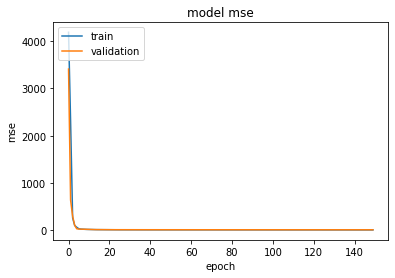

In [25]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
pred = model.predict(X_test).tolist()
pred = [p[0] for p in pred]
mean_squared_error(np.array(y_test), pred)

10.733655291650932

In [27]:
r2_score(np.array(y_test), pred)

0.9462946636131494

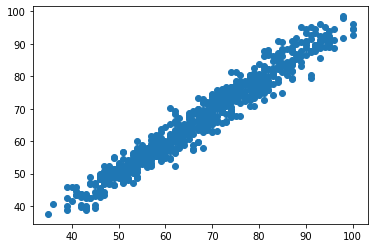

In [28]:
plt.scatter(y_test, pred)

- Neural network performed well, as epoch increased, MSE dropped.
- However multiple regression outperformed neural network

# Regression without pretest variable

In [29]:
%%R
df.clean <- subset(df, select=-c(student_id, pretest))

#approx 3/4 of whole dataset
inds <- sample(nrow(df.clean), 1700)
train <- df.clean[inds,]
test <- df.clean[-inds,]

fit1 <- lm(posttest ~ ., data=train)
Anova(fit1)

      sums of squares computed by model comparison



Anova Table (Type II tests)

Response: posttest
                Sum Sq   Df F value    Pr(>F)    
school                    0                      
school_setting            0                      
school_type               0                      
classroom        39774   72  57.986 < 2.2e-16 ***
teaching_method           0                      
n_student                 0                      
gender             125    1  13.148 0.0002969 ***
lunch             1367    1 143.494 < 2.2e-16 ***
Residuals        15252 1601                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R
train.clean.2 <- subset(train, select=-c(school, school_setting, school_type, teaching_method, n_student))

fit2 <- lm(posttest ~ ., data=train.clean.2)
Anova(fit2)

Anova Table (Type II tests)

Response: posttest
          Sum Sq   Df F value    Pr(>F)    
classroom 192659   96 210.656 < 2.2e-16 ***
gender       125    1  13.148 0.0002969 ***
lunch       1367    1 143.494 < 2.2e-16 ***
Residuals  15252 1601                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
%%R
X_test <- subset(test, select=-c(school, school_setting, school_type, n_student, teaching_method, posttest))
Y_test <- subset(test, select=posttest)
preds <- predict(fit2, X_test)

In [32]:
ytest = %R Y_test
pred = %R preds
ytest, pred = eval(ytest, pred)

MSE: 9.353581947518396
R2Score: 0.9552424796975344


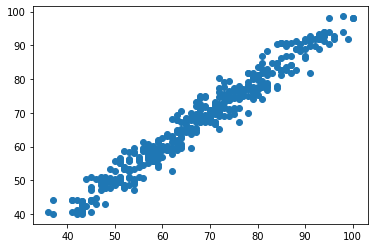

In [33]:
plt.scatter(ytest, pred)

Accuracy decreased slightly compared to the model with pretest variable. 

---
# TREE
- Same data that I used for neural nets

In [34]:
df_new = df.drop(columns=["student_id"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Decision Tree

In [35]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 16.631046796085858
R2Score: 0.9167873442569008


In [36]:
importance = clf.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
X_train.columns[sorted_indices]
def top_features(model):
    importance = model.feature_importances_
    sorted_indices = np.argsort(importance)[::-1][:10]
    cols = X_train.columns[sorted_indices]
    importance_dict={X_train.columns[i]:importance[i] for i in sorted_indices}
    plt.figure(figsize=(15,15))
    plt.barh(cols, importance[sorted_indices])
    plt.gca().invert_yaxis()

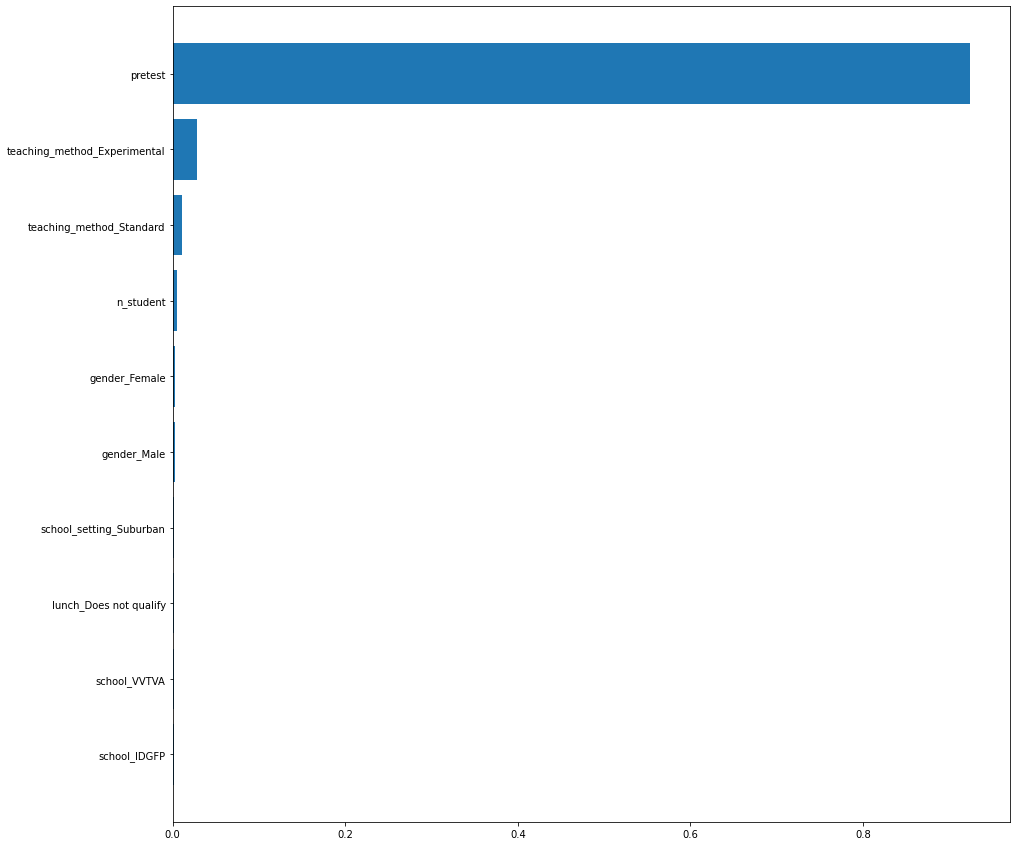

In [37]:
top_features(clf)

In [38]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 11.094995688511277
R2Score: 0.9444867140343477


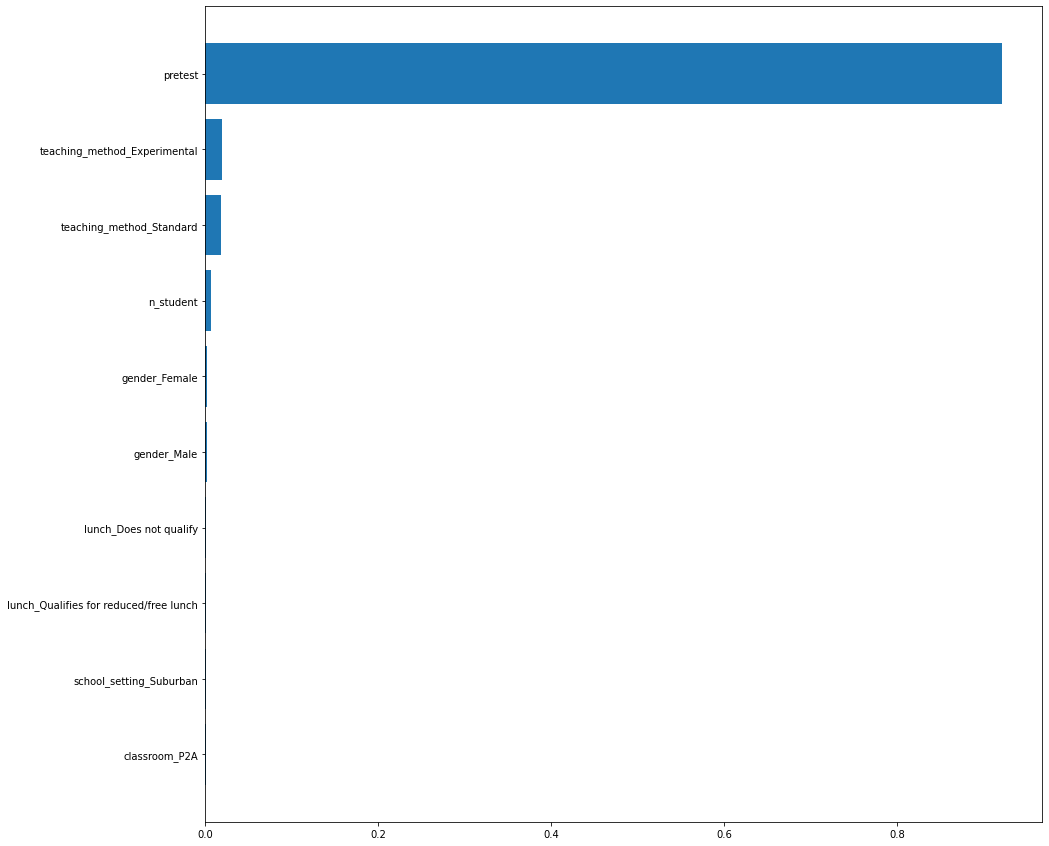

In [40]:
top_features(rf)

### LGBM

In [41]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
evals=[(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=evals, eval_metric="mse")
pred = lgbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

[1]	valid_0's l2: 164.567	valid_0's l2: 164.567
[2]	valid_0's l2: 135.768	valid_0's l2: 135.768
[3]	valid_0's l2: 112.292	valid_0's l2: 112.292
[4]	valid_0's l2: 93.3963	valid_0's l2: 93.3963
[5]	valid_0's l2: 77.7389	valid_0's l2: 77.7389
[6]	valid_0's l2: 65.2135	valid_0's l2: 65.2135
[7]	valid_0's l2: 54.9428	valid_0's l2: 54.9428
[8]	valid_0's l2: 46.7366	valid_0's l2: 46.7366
[9]	valid_0's l2: 39.9751	valid_0's l2: 39.9751
[10]	valid_0's l2: 34.513	valid_0's l2: 34.513
[11]	valid_0's l2: 30.0109	valid_0's l2: 30.0109
[12]	valid_0's l2: 26.334	valid_0's l2: 26.334
[13]	valid_0's l2: 23.3854	valid_0's l2: 23.3854
[14]	valid_0's l2: 20.9653	valid_0's l2: 20.9653
[15]	valid_0's l2: 19.0243	valid_0's l2: 19.0243
[16]	valid_0's l2: 17.3803	valid_0's l2: 17.3803
[17]	valid_0's l2: 16.0843	valid_0's l2: 16.0843
[18]	valid_0's l2: 15.0054	valid_0's l2: 15.0054
[19]	valid_0's l2: 14.0884	valid_0's l2: 14.0884
[20]	valid_0's l2: 13.3617	valid_0's l2: 13.3617
[21]	valid_0's l2: 12.761	valid_0

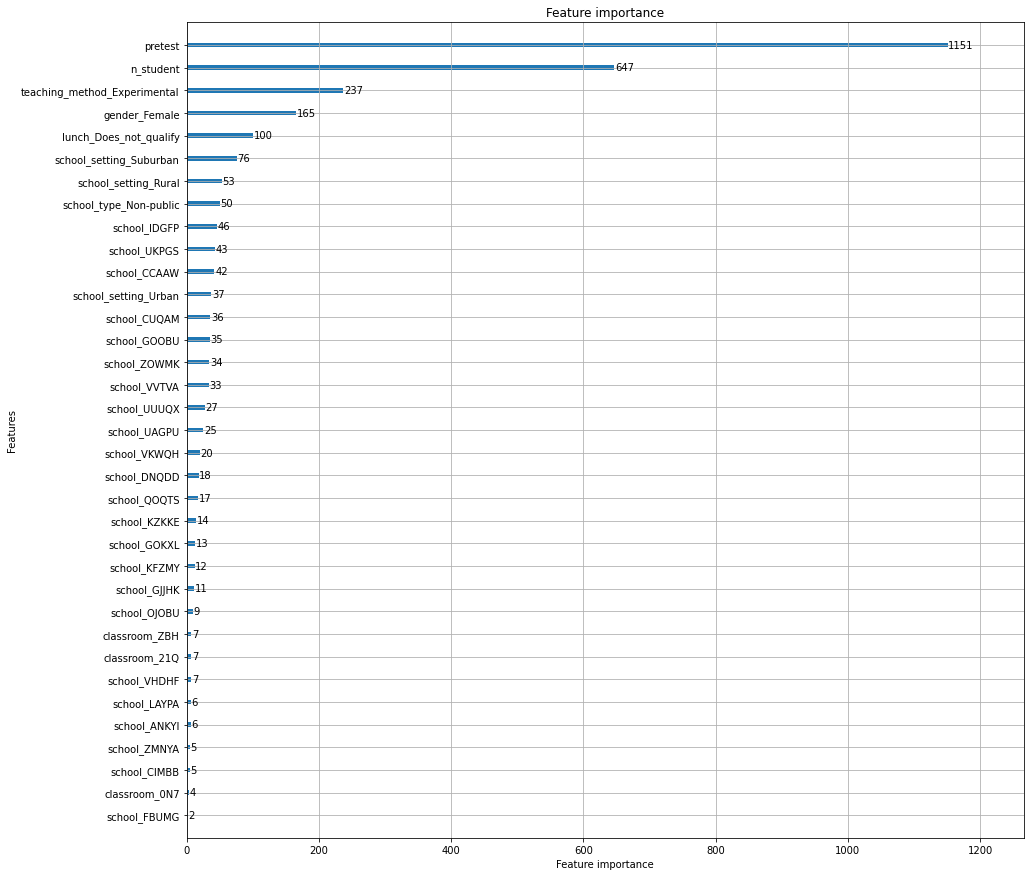

In [42]:
from lightgbm import plot_importance
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
plot_importance(lgbm, ax=ax)

????? n_students and teaching method turned out to be very impactful.....?
I can probably adjust the parameters of the models and use cross validation to improve the performance. Although the difference is marginal, performance is LGBM > RandomForest > DecisionTrees.

---
# Tree Models without pretest variable

In [43]:
df_new = df.drop(columns=["student_id", "pretest"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 13.167171805419304
R2Score: 0.9341186788788023


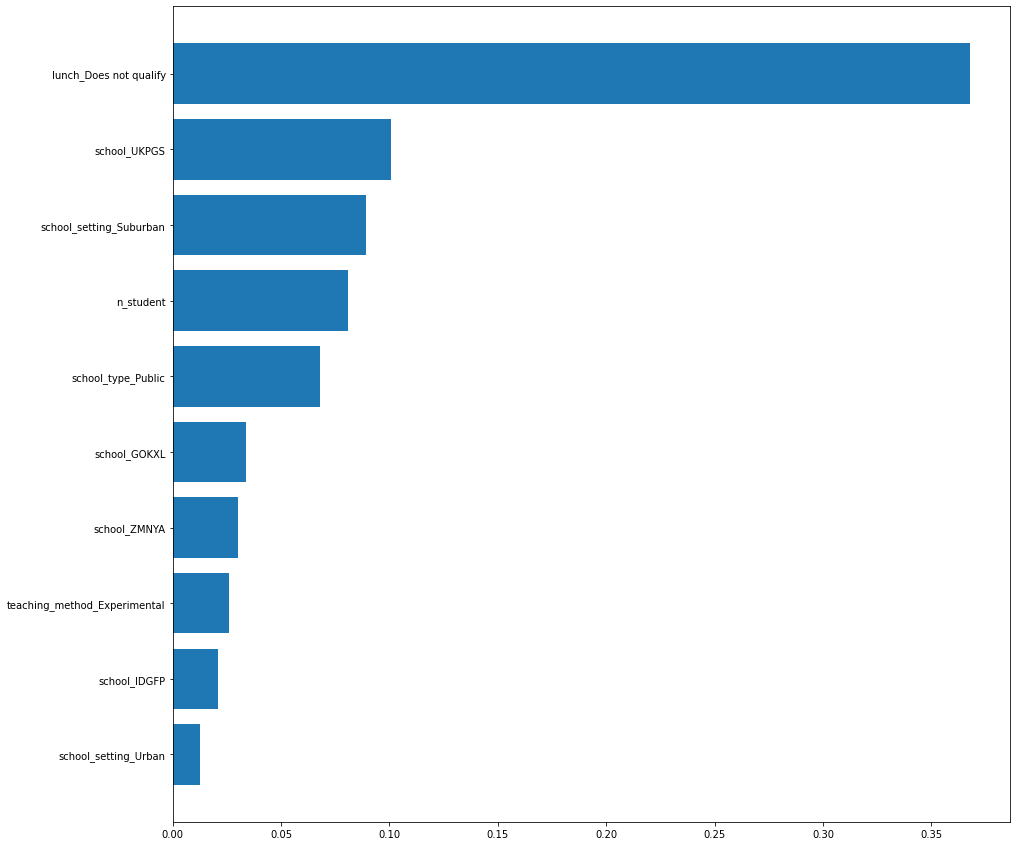

In [45]:
top_features(clf)

MSE: 13.167171805419304
R2Score: 0.9341186788788023


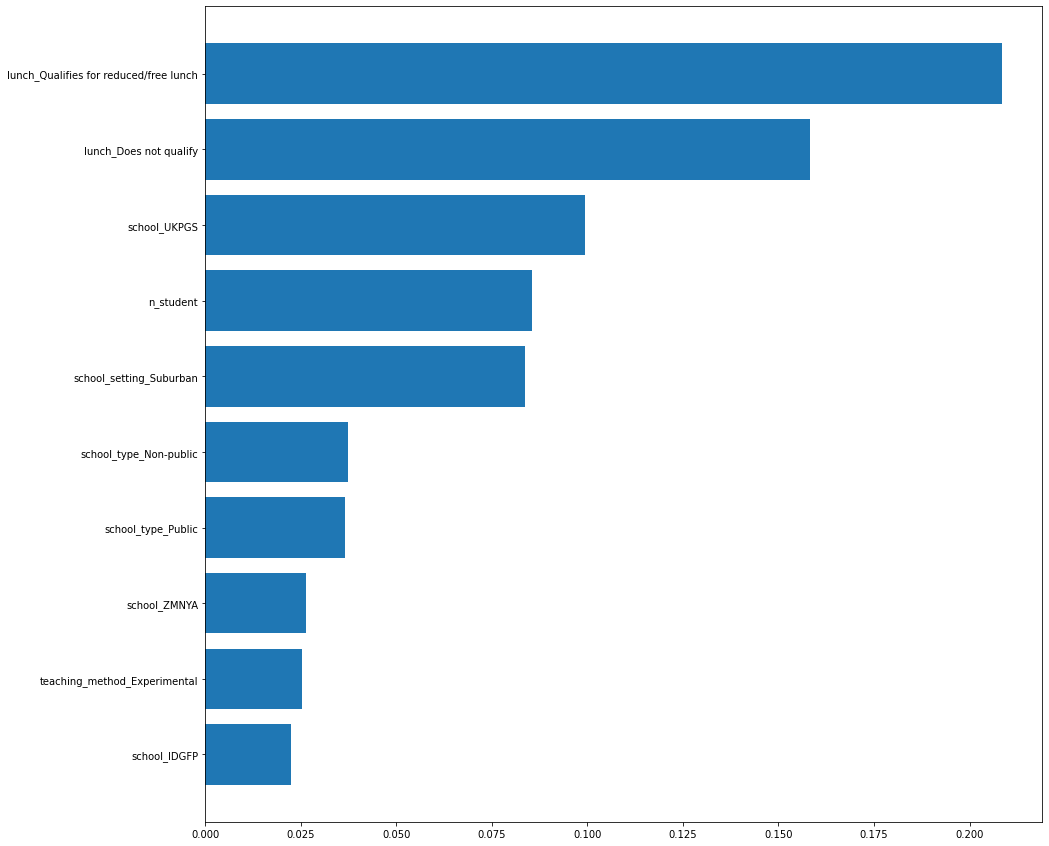

In [46]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rfpred = rf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")
top_features(rf)

In [47]:
import plotly.express as px
px.line(X_test, rfpred)

In [48]:
lgbm = LGBMRegressor()
evals=[(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=evals, eval_metric="mse")
pred = lgbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

[1]	valid_0's l2: 167.967	valid_0's l2: 167.967
[2]	valid_0's l2: 141.956	valid_0's l2: 141.956
[3]	valid_0's l2: 120.358	valid_0's l2: 120.358
[4]	valid_0's l2: 102.967	valid_0's l2: 102.967
[5]	valid_0's l2: 88.6734	valid_0's l2: 88.6734
[6]	valid_0's l2: 77.1177	valid_0's l2: 77.1177
[7]	valid_0's l2: 67.7473	valid_0's l2: 67.7473
[8]	valid_0's l2: 60.207	valid_0's l2: 60.207
[9]	valid_0's l2: 53.6887	valid_0's l2: 53.6887
[10]	valid_0's l2: 48.338	valid_0's l2: 48.338
[11]	valid_0's l2: 43.9265	valid_0's l2: 43.9265
[12]	valid_0's l2: 40.3943	valid_0's l2: 40.3943
[13]	valid_0's l2: 37.1456	valid_0's l2: 37.1456
[14]	valid_0's l2: 34.487	valid_0's l2: 34.487
[15]	valid_0's l2: 32.418	valid_0's l2: 32.418
[16]	valid_0's l2: 30.6764	valid_0's l2: 30.6764
[17]	valid_0's l2: 29.1837	valid_0's l2: 29.1837
[18]	valid_0's l2: 27.7663	valid_0's l2: 27.7663
[19]	valid_0's l2: 26.7717	valid_0's l2: 26.7717
[20]	valid_0's l2: 25.7398	valid_0's l2: 25.7398
[21]	valid_0's l2: 24.9545	valid_0's 

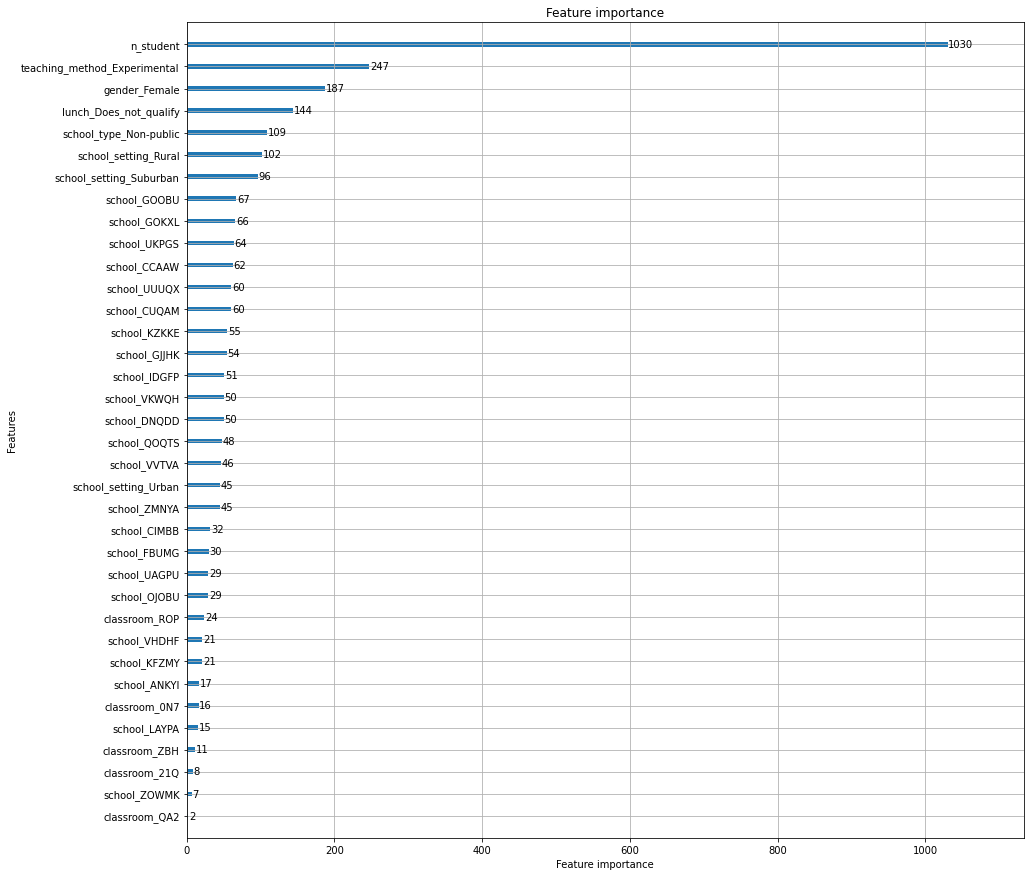

In [49]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(lgbm, ax=ax)

# Cross validation w/ xgboost

In [50]:
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
dtr = tree.DecisionTreeRegressor(max_depth=7)
rf = RandomForestRegressor()
xgb = XGBRegressor(n_estimators=1000, verbosity=0)

models = [lr, dtr, rf, xgb]

scoring = {'r2': 'r2',
          'mse':'neg_mean_squared_error'}

for model in models:
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    print(model.__class__.__name__)
    print(f"Average train r2: {np.mean(scores['train_r2'])}")
    print(f"Average test r2: {np.mean(scores['test_r2'])}")
    print(f"Average train mse: {np.mean(scores['train_mse']) * -1}")
    print(f"Average test mse: {np.mean(scores['test_mse']) * -1}\n")

LinearRegression
Average train r2: 0.9528623138915716
Average test r2: -8.548824930149896e+22
Average train mse: 9.011292722684868
Average test mse: 1.2680295393929338e+25

DecisionTreeRegressor
Average train r2: 0.8898031741412533
Average test r2: -0.04739757836310683
Average train mse: 21.17715195639982
Average test mse: 144.749720057621

RandomForestRegressor
Average train r2: 0.957768404643787
Average test r2: 0.0432470301282873
Average train mse: 8.080856135601696
Average test mse: 133.90171768637205

XGBRegressor
Average train r2: 0.957539507672035
Average test r2: 0.18359715426160586
Average train mse: 8.125014696801657
Average test mse: 109.57398430479354



I feel like the scores are very wrong...

# xgboost alone

In [51]:
xgb = XGBRegressor(n_estimators=1000, verbosity=0)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, preds)}")
print(f"R2Score: {r2_score(y_test, preds)}")

MSE: 11.515308654575703
R2Score: 0.9423836979958317


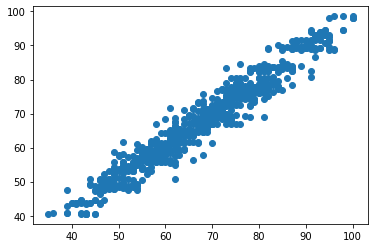

In [52]:
plt.scatter(y_test, preds)

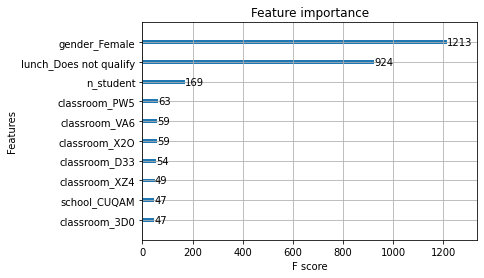

In [53]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)

Gender is an important variable here

---
# Thoughts
- Pretest variable is definetely the most significant variable since it is strongly correlated to the posttest variable. However when the pretest variable is removed the models still manage to perform well. Significant variables were gender and lunch in this case.